In [1]:
%matplotlib inline
import tensorflow as tf
from os import system
import random
import vizdoom as vd
from vizdoom import *
import numpy as np
import scipy.ndimage as Simg
# import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
from ennemies import *
import map_parser

from basic_ennemy_pos import basic_ennemy_x
from network import tf, DRQN
from video import VideoWriter
from memory import ReplayMemory
import map_parser

In [3]:
# Replay memory minimum and maximum size
MIN_MEM_SIZE, MAX_MEM_SIZE = 8000, 80000
# Batch size for NN ingestion
BATCH_SIZE = 32
# Sequence length for NN ingestion
SEQUENCE_LENGTH = 8
# Number of states to ignore when computing loss
IGNORE_UP_TO = 4
# Maximum episode duration, in frames
# MAX_EPISODE_LENGTH = 125  # 500 with a frame skip of 4 #basic
# MAX_EPISODE_LENGTH = 525 # dealy co
MAX_EPISODE_LENGTH = 2000 # defend_the_line
# Number of training steps
TRAINING_STEPS = 1000
# Number of backpropagation steps to execute after each episode
BACKPROP_STEPS = 15
# Number of training steps
QLEARNING_STEPS = 5000
# Number of steps during which epsilon should be decreased
GREEDY_STEPS = 1000
# Maximum number of cores to use
MAX_CPUS = 32
# Learning rate for tensorflow optimizers
LEARNING_RATE = 0.001
# Use the game features in the learning phase
USE_GAME_FEATURES = True
# Use LSTM or simple DQN
USE_RECURRENCE = True
# Learn Q in the learning phase
LEARN_Q = True

DEATH_PENALTY = 25
KILL_REWARD = 100
PICKUP_REWARD = 4

# Config variables
im_w, im_h = 108, 60
N_FEATURES = 6
N_ACTIONS = 3 ###############
ACTION_SET = np.eye(N_ACTIONS, dtype=np.uint32).tolist()
SECTION_SEPARATOR = "------------"

GAME_NAME = 'defend_the_line'

In [ ]:
# Need to be imported andaga created after wrap_play_random_episode
from multiprocessing import Pool, cpu_count
N_CORES = min(cpu_count(), MAX_CPUS)
N_CORES = 0
if N_CORES > 1:
    workers = Pool(N_CORES)

In [3]:
# Neural nets and tools
print('Building main DRQN')
main = DRQN(im_h, im_w, N_FEATURES, N_ACTIONS, 'main', LEARNING_RATE,
            use_game_features=USE_GAME_FEATURES, learn_q=LEARN_Q,
            recurrent=USE_RECURRENCE)
print('Building target DRQN')
target = DRQN(im_h, im_w, N_FEATURES, N_ACTIONS, 'target', LEARNING_RATE, True,
        recurrent=USE_RECURRENCE)
saver = tf.train.Saver()
mem = ReplayMemory(MIN_MEM_SIZE, MAX_MEM_SIZE)

Building main DRQN
Learn Q only
Building target DRQN


In [2]:
visible = False
game = vd.DoomGame()
# game.load_config("basic.cfg")
# game.load_config("scenarios/"+GAME+".cfg")
game.load_config("scenarios/deadly_corridor.cfg")
game.set_screen_format(ScreenFormat.RGB24)
game.set_depth_buffer_enabled(True)

# Ennemy detection
walls = map_parser.parse("maps/deathmatch.txt")
game.clear_available_game_variables()
game.add_available_game_variable(vd.GameVariable.POSITION_X)  # 0
game.add_available_game_variable(vd.GameVariable.POSITION_Y)  # 1
game.add_available_game_variable(vd.GameVariable.POSITION_Z)  # 2

game.add_available_game_variable(vd.GameVariable.KILLCOUNT)   # 3
game.add_available_game_variable(vd.GameVariable.DEATHCOUNT)  # 4
game.add_available_game_variable(vd.GameVariable.ITEMCOUNT)   # 5

game.set_labels_buffer_enabled(True)
game.set_window_visible(visible)

game.init()

In [4]:
game.init()

In [5]:
game.state

AttributeError: 'vizdoom.vizdoom.DoomGame' object has no attribute 'state'

In [8]:
verbose=False
skip=1
game.new_episode()
dump = []
zoomed = np.zeros((MAX_EPISODE_LENGTH, im_h, im_w, 3), dtype=np.uint8)
action = ACTION_SET[0]
while not game.is_episode_finished():
    # Get screen buf
    state = game.get_state()
    S = state.screen_buffer  # NOQA

    # Resample to our network size
    h, w = S.shape[:2]
    Simg.zoom(S, [1. * im_h / h, 1. * im_w / w, 1],
              output=zoomed[len(dump)], order=0)
    S = zoomed[len(dump)]  # NOQA

    # Get game features an action
    game_features = [basic_ennemy_x(state)]
    action = random.choice(ACTION_SET)
    reward = game.make_action(action, skip)
    dump.append((S, action, reward, game_features))
return dump

IndexError: index 525 is out of bounds for axis 0 with size 525

In [16]:
np.shape(S)

(240, 320, 3)

In [12]:
np.shape(zoomed)

(525, 60, 108, 3)

In [13]:
np.shape(dump)

(525, 4)

In [14]:
zoomed[525]

IndexError: index 525 is out of bounds for axis 0 with size 525

In [4]:
game = vd.DoomGame()
# game.set_doom_game_path("scenarios/deathmatch.wad")
game.load_config("scenarios/basic.cfg")
game.set_screen_format(ScreenFormat.RGB24)

game.set_depth_buffer_enabled(True)
game.set_labels_buffer_enabled(True)

# Ennemy detection
walls = None  # map_parser.parse("maps/deathmatch.txt")
game.clear_available_game_variables()
game.add_available_game_variable(vd.GameVariable.POSITION_X)  # 0
game.add_available_game_variable(vd.GameVariable.POSITION_Y)  # 1
game.add_available_game_variable(vd.GameVariable.POSITION_Z)  # 2

game.add_available_game_variable(vd.GameVariable.KILLCOUNT)   # 3
game.add_available_game_variable(vd.GameVariable.DEATHCOUNT)  # 4
game.add_available_game_variable(vd.GameVariable.ITEMCOUNT)   # 5

game.add_available_game_variable(vd.GameVariable.HEALTH)  # 6
game.add_available_game_variable(vd.GameVariable.AMMO5)  # 7
game.add_available_game_variable(vd.GameVariable.FRAGCOUNT)  # 8


game.clear_available_buttons()
game.add_available_button(TURN_LEFT) #1
game.add_available_button(TURN_RIGHT) #2
game.add_available_button(ATTACK) #3
game.add_available_button(MOVE_FORWARD_BACKWARD_DELTA) #4
game.add_available_button(MOVE_RIGHT) #5
game.add_available_button(TURN_LEFT_RIGHT_DELTA) #6
game.add_available_button(TURN180) #7

game.set_render_hud(False)
game.set_render_crosshair(True)
game.set_render_weapon(True)
game.set_render_decals(False)
game.set_render_particles(False)

game.init()

In [9]:
game.get_available_buttons_size()

7

In [60]:
game.new_episode()

In [61]:
state=game.get_state()

In [22]:
game.make_action(ACTION_SET[1])

0.0

In [23]:
ACTION_SET[1]

[0, 1, 0]

In [24]:
ACTION_SET = np.eye(7, dtype=np.uint32).tolist()

In [25]:
game.make_action(ACTION_SET[6])

0.0

In [26]:
ACTION_SET

[[1, 0, 0, 0, 0, 0, 0],
 [0, 1, 0, 0, 0, 0, 0],
 [0, 0, 1, 0, 0, 0, 0],
 [0, 0, 0, 1, 0, 0, 0],
 [0, 0, 0, 0, 1, 0, 0],
 [0, 0, 0, 0, 0, 1, 0],
 [0, 0, 0, 0, 0, 0, 1]]

In [30]:
state.labels[1].object_position_x

1024.0

In [31]:
state.depth_buffer[65]

array([12, 12, 12, 12, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 14, 14,
       14, 14, 14, 14, 14, 14, 14, 15, 15, 15, 15, 15, 15, 15, 15, 16, 16,
       16, 16, 16, 16, 16, 17, 17, 17, 17, 17, 17, 17, 18, 18, 18, 18, 18,
       18, 19, 19, 19, 19, 19, 20, 20, 20, 20, 20, 21, 21, 21, 21, 22, 22,
       22, 22, 23, 23, 23, 23, 24, 24, 24, 25, 25, 25, 26, 26, 26, 27, 27,
       27, 28, 28, 29, 29, 29, 30, 30, 30, 31, 31, 31, 31, 32, 32, 32, 32,
       33, 33, 33, 33, 34, 34, 34, 34, 35, 35, 35, 35, 36, 36, 36, 37, 37,
       37, 38, 38, 38, 39, 39, 39, 40, 40, 40, 41, 41, 42, 41, 41, 41, 41,
       41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41,
       41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41,
       41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41,
       41, 41, 42, 41, 41, 40, 40, 40, 39, 39, 39, 38, 38, 38, 37, 37, 37,
       36, 36, 36, 35, 35, 35, 35, 34, 34, 34, 34, 33, 33, 33, 33, 32, 32,
       32, 32, 31, 31, 31

In [32]:
labels

NameError: name 'labels' is not defined

In [14]:
len(state.labels)

7

In [45]:
cv2.imshow('ViZDoom Labels Buffer', state.labels_buffer)

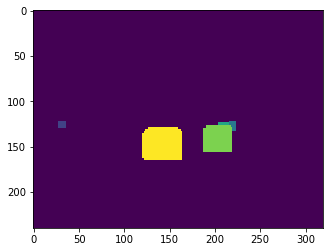

In [46]:
plt.imshow(state.labels_buffer)

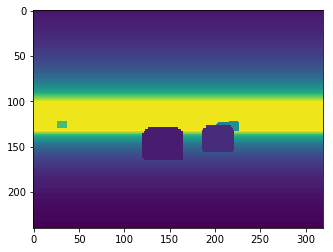

In [47]:
plt.imshow(state.depth_buffer)

In [48]:
state.depth_buffer[65]

array([29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29,
       29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29,
       29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29,
       29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29,
       29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29,
       29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29,
       29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29,
       29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29,
       29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29,
       29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29,
       29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29,
       29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29,
       29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29,
       29, 29, 29, 29, 29

In [49]:
state.depth_buffer

array([[12, 12, 12, ..., 12, 12, 12],
       [12, 12, 12, ..., 12, 12, 12],
       [12, 12, 12, ..., 12, 12, 12],
       ..., 
       [ 7,  7,  7, ...,  7,  7,  7],
       [ 7,  7,  7, ...,  7,  7,  7],
       [ 7,  7,  7, ...,  7,  7,  7]], dtype=uint8)

In [50]:
print("Player position X:", state.game_variables[0], "Y:", state.game_variables[1], "Z:", state.game_variables[2])

Player position X: 608.0 Y: 608.0 Z: 0.0


In [56]:
for l in state.labels:
            print("Object id:", l.object_id, "object name:", l.object_name, "label:", l.value)
            print("Object position X:", l.object_position_x, "Y:", l.object_position_y, "Z:", l.object_position_z)

Object id: 1 object name: Medikit label: 42
Object position X: 1065.418441772461 Y: 975.5387268066406 Z: 20.0
Object id: 2 object name: Medikit label: 85
Object position X: 958.8507232666016 Y: 475.75146484375 Z: 20.0
Object id: 3 object name: Medikit label: 127
Object position X: 914.7549743652344 Y: 514.2530822753906 Z: 20.0
Object id: 4 object name: Medikit label: 212
Object position X: 709.8167724609375 Y: 620.045654296875 Z: 20.0
Object id: 5 object name: Medikit label: 170
Object position X: 734.8082275390625 Y: 574.1287689208984 Z: 20.0


In [63]:
walls = map_parser.parse("maps/basic.txt")

In [66]:
map_parser.plot_map("deathmatch")

In [65]:
has_visible_entities(state,maps)

[True, False, False]

In [52]:
has_visible(state,walls,ENNEMIES)

False

In [31]:
entities = get_cone_entities(state,ENNEMIES)

In [30]:
state.game_variables[0], state.game_variables[1]

(0.0, 0.0)

In [36]:
entities[5].object_position_x

160.0

In [39]:
walls

[((-32.0, -32.0), (-32.0, 32.0)),
 ((1344.0, -32.0), (1184.0, -32.0)),
 ((1344.0, 32.0), (1344.0, -32.0)),
 ((1184.0, -32.0), (1088.0, -96.0)),
 ((-32.0, 32.0), (96.0, 96.0)),
 ((448.0, 32.0), (544.0, 96.0)),
 ((-32.0, 32.0), (352.0, 32.0)),
 ((1184.0, -32.0), (864.0, -32.0)),
 ((448.0, -32.0), (352.0, -32.0)),
 ((864.0, -32.0), (768.0, -32.0)),
 ((224.0, 96.0), (352.0, 32.0)),
 ((544.0, 96.0), (672.0, 96.0)),
 ((1184.0, 32.0), (1344.0, 32.0)),
 ((448.0, 32.0), (768.0, 32.0)),
 ((352.0, 32.0), (448.0, 32.0)),
 ((224.0, -96.0), (96.0, -96.0)),
 ((544.0, -96.0), (448.0, -32.0)),
 ((352.0, -32.0), (224.0, -96.0)),
 ((352.0, -32.0), (-32.0, -32.0)),
 ((1088.0, -96.0), (960.0, -96.0)),
 ((96.0, 96.0), (224.0, 96.0)),
 ((96.0, -96.0), (-32.0, -32.0)),
 ((672.0, -96.0), (544.0, -96.0)),
 ((960.0, -96.0), (864.0, -32.0)),
 ((768.0, -32.0), (672.0, -96.0)),
 ((768.0, -32.0), (448.0, -32.0)),
 ((864.0, 32.0), (960.0, 96.0)),
 ((672.0, 96.0), (768.0, 32.0)),
 ((1088.0, 96.0), (1184.0, 32.0)),
 ((

In [5]:
def plot_map2(map, ennemies=None, player_pos=None):
    import matplotlib.pyplot as plt

    walls = map_parser.parse("maps/%s" % map)
    for a, b in walls:
        ax, ay = a
        bx, by = b
        plt.plot([ax, bx], [ay, by])

    if ennemies:
        for e in ennemies:
            plt.plot([e.object_position_x], [e.object_position_y], 'ro')

    if player_pos:
        plt.plot([player_pos[0]], [player_pos[1]], 'bo')

    # plt.show()
    plt.savefig("%s.png" % map)
    plt.close()

In [7]:
os.listdir("maps")

['basic.txt',
 'cig1.txt',
 'cig2.txt',
 'deadly_corridor.txt',
 'deathmatch.txt',
 'defend_the_center.txt',
 'defend_the_line.txt',
 'health_gathering.txt',
 'health_gathering_supreme.txt',
 'multi_deathmatch.txt',
 'multi_duel.txt',
 'my_way_home.txt',
 'predict_position.txt',
 'rocket_basic.txt',
 'simpler_basic.txt',
 'take_cover.txt']

In [8]:
for i in os.listdir("maps"):
    plot_map2(i)

In [4]:
game.new_episode()

In [5]:
state = game.get_state()

In [6]:
state.screen_buffer

array([[[19, 43, 51],
        [19, 43, 51],
        [35, 51, 71],
        ..., 
        [27, 47, 67],
        [27, 47, 67],
        [19, 35, 55]],

       [[27, 47, 67],
        [19, 43, 51],
        [19, 35, 55],
        ..., 
        [19, 35, 55],
        [19, 35, 55],
        [19, 35, 55]],

       [[27, 47, 67],
        [27, 47, 67],
        [19, 35, 55],
        ..., 
        [19, 35, 55],
        [19, 35, 55],
        [19, 35, 55]],

       ..., 
       [[19, 19, 19],
        [19, 19, 19],
        [11, 11, 11],
        ..., 
        [47, 47, 47],
        [47, 47, 47],
        [55, 55, 55]],

       [[19, 19, 19],
        [27, 27, 27],
        [19, 19, 19],
        ..., 
        [47, 47, 47],
        [47, 47, 47],
        [47, 47, 47]],

       [[11, 11, 11],
        [19, 19, 19],
        [19, 19, 19],
        ..., 
        [27, 27, 27],
        [19, 19, 19],
        [19, 19, 19]]], dtype=uint8)

In [7]:
h, w, d = state.screen_buffer.shape

In [13]:
a = Simg.zoom(state.screen_buffer, [1. * 200 / h, 1. * 100 / w, 1],
                           order=0)

In [14]:
np.shape(a)

(200, 100, 3)

In [17]:
a[1,2,1]

43

In [19]:
m = 0
for i in range(200):
    for j in range(100):
        for k in range(3):
            if(a[i,j,k] > m):
                m = a[i,j,k]
            

In [20]:
m

255

In [21]:
a/255.

array([[[ 0.0745098 ,  0.16862745,  0.2       ],
        [ 0.1372549 ,  0.2       ,  0.27843137],
        [ 0.16862745,  0.27843137,  0.24705882],
        ..., 
        [ 0.1372549 ,  0.2       ,  0.27843137],
        [ 0.10588235,  0.16862745,  0.24705882],
        [ 0.0745098 ,  0.1372549 ,  0.21568627]],

       [[ 0.10588235,  0.18431373,  0.2627451 ],
        [ 0.0745098 ,  0.1372549 ,  0.21568627],
        [ 0.10588235,  0.16862745,  0.24705882],
        ..., 
        [ 0.1372549 ,  0.2       ,  0.27843137],
        [ 0.10588235,  0.16862745,  0.24705882],
        [ 0.0745098 ,  0.1372549 ,  0.21568627]],

       [[ 0.10588235,  0.18431373,  0.2627451 ],
        [ 0.0745098 ,  0.1372549 ,  0.21568627],
        [ 0.10588235,  0.16862745,  0.24705882],
        ..., 
        [ 0.0745098 ,  0.1372549 ,  0.21568627],
        [ 0.0745098 ,  0.1372549 ,  0.21568627],
        [ 0.0745098 ,  0.1372549 ,  0.21568627]],

       ..., 
       [[ 0.0745098 ,  0.0745098 ,  0.0745098 ],
        

In [22]:
state.screen_buffer/255.0

array([[[ 0.0745098 ,  0.16862745,  0.2       ],
        [ 0.0745098 ,  0.16862745,  0.2       ],
        [ 0.1372549 ,  0.2       ,  0.27843137],
        ..., 
        [ 0.10588235,  0.18431373,  0.2627451 ],
        [ 0.10588235,  0.18431373,  0.2627451 ],
        [ 0.0745098 ,  0.1372549 ,  0.21568627]],

       [[ 0.10588235,  0.18431373,  0.2627451 ],
        [ 0.0745098 ,  0.16862745,  0.2       ],
        [ 0.0745098 ,  0.1372549 ,  0.21568627],
        ..., 
        [ 0.0745098 ,  0.1372549 ,  0.21568627],
        [ 0.0745098 ,  0.1372549 ,  0.21568627],
        [ 0.0745098 ,  0.1372549 ,  0.21568627]],

       [[ 0.10588235,  0.18431373,  0.2627451 ],
        [ 0.10588235,  0.18431373,  0.2627451 ],
        [ 0.0745098 ,  0.1372549 ,  0.21568627],
        ..., 
        [ 0.0745098 ,  0.1372549 ,  0.21568627],
        [ 0.0745098 ,  0.1372549 ,  0.21568627],
        [ 0.0745098 ,  0.1372549 ,  0.21568627]],

       ..., 
       [[ 0.0745098 ,  0.0745098 ,  0.0745098 ],
        

In [ ]:
np.shape(state.screen_buffer)